In [1]:
#Transfer learning code with VGG16 network (Keras)
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.models import Input, Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

import numpy as np
from matplotlib import pyplot as plt
from glob import glob

Using TensorFlow backend.


In [2]:
#in case of loading VGG16 model without output layer and specify new input shape  [new_input = Input(shape=(112, 112, 3))]
#model = VGG16(include_top=False, input_tensor=new_input, pooling='avg') with new input layer and global averaging layer
new_input_shape = Input(shape=(112, 112, 3))
trainable_model = VGG16(include_top=False,input_tensor=new_input_shape) 
trainable_model.summary()











_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 112, 112, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)       0         


In [3]:
# Freeze all the layers
for layer in trainable_model.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in trainable_model.layers:
    print(layer, layer.trainable)


<keras.engine.input_layer.InputLayer object at 0x000001CCB420FD68> False
<keras.layers.convolutional.Conv2D object at 0x000001CCB420FDA0> False
<keras.layers.convolutional.Conv2D object at 0x000001CC8AE44780> False
<keras.layers.pooling.MaxPooling2D object at 0x000001CC8AE80A20> False
<keras.layers.convolutional.Conv2D object at 0x000001CC8AE8CEF0> False
<keras.layers.convolutional.Conv2D object at 0x000001CC8AE92EF0> False
<keras.layers.pooling.MaxPooling2D object at 0x000001CC8AE9ADA0> False
<keras.layers.convolutional.Conv2D object at 0x000001CC8AEA2C50> False
<keras.layers.convolutional.Conv2D object at 0x000001CC8AEA94A8> False
<keras.layers.convolutional.Conv2D object at 0x000001CC8AEB0518> False
<keras.layers.pooling.MaxPooling2D object at 0x000001CC8AEB7CC0> False
<keras.layers.convolutional.Conv2D object at 0x000001CC8AEC07B8> False
<keras.layers.convolutional.Conv2D object at 0x000001CC8AEC3390> False
<keras.layers.convolutional.Conv2D object at 0x000001CC8AECE208> False
<ker

In [4]:
# Add the custom last layers to retrain
custom_model = Sequential()
custom_model.add(trainable_model)
custom_model.add(Flatten())
custom_model.add(Dense(1024, activation='relu'))
custom_model.add(Dropout(0.5))
custom_model.add(Dense(10, activation='softmax'))
custom_model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              4719616   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10250     
Total params: 19,444,554
Trainable params: 4,729,866
Non-trainable params: 14,714,688
_________________________________________________________________


In [5]:
# Load the normalized images
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_dir="./animal_dataset/train/"
validation_dir="./animal_dataset/validation/"
image_size=112

# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10

# Data generator for training data
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(image_size, image_size),batch_size=train_batchsize,class_mode='categorical')

# Data generator for validation data
validation_generator = validation_datagen.flow_from_directory(validation_dir,target_size=(image_size, image_size),batch_size=val_batchsize,class_mode='categorical', shuffle=False)


Found 11300 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [6]:
# Configure the model for training
custom_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Define callbacks
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
checkpoint = ModelCheckpoint(filepath='./saved_weights/best_animal_model.h5', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='auto', period=1)

# Train the model
history = custom_model.fit_generator(
      train_generator,
      steps_per_epoch=
         train_generator.samples/train_generator.batch_size,
      epochs=100,
      validation_data=validation_generator, 
      validation_steps=
         validation_generator.samples/validation_generator.batch_size,
      verbose=1, callbacks=[lr_reducer, early_stopper, checkpoint])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
113/113 [==============================] - 47s 420ms/step - loss: 1.4677 - acc: 0.4940 - val_loss: 1.0991 - val_acc: 0.6325

Epoch 00001: val_loss improved from inf to 1.09912, saving model to ./saved_weights/best_animal_model.h5
Epoch 2/100
113/113 [==============================] - 43s 383ms/step - loss: 1.0224 - acc: 0.6566 - val_loss: 0.9393 - val_acc: 0.6935

Epoch 00002: val_loss improved from 1.09912 to 0.93927, saving model to ./saved_weights/best_animal_model.h5
Epoch 3/100
113/113 [==============================] - 43s 381ms/step - loss: 0.8768 - acc: 0.7067 - val_loss: 0.8649 - val_acc: 0.6995

Epoch 00003: val_loss improved from 0.93927 to 0.86492, saving model to ./saved_weights/best_animal_model.h5
Epoch 4/100
113/113 [==============================] - 43s 380ms/step - loss: 0.7780 - acc: 0.7428 - val_loss: 0.8302 - val_acc: 0.7115

Epoch 00004: val_loss improved 

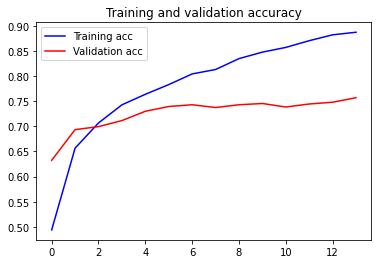

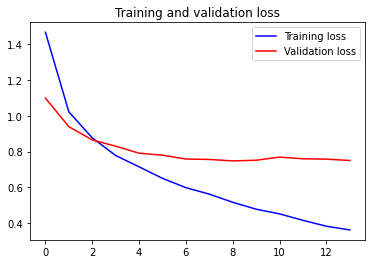

In [15]:
# Utility function for plotting of the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


# Run the function to illustrate accuracy and loss
visualize_results(history)

# Save History Training
np.save('./saved_weights/training_history_best_animal_model.npy', history.history)

# To load History Training later on
#loaded_history = np.load('./saved_weights/training_history_best_animal_model.npy', allow_pickle=True)